In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
import os
os.environ['CXX'] = 'g++'

In [3]:
import arviz
import numpy as np
import pymc3 as pm
from tqdm import tqdm

In [4]:
from IPython.display import display

In [5]:
import scipy.stats.distributions as dist

In [6]:
def get_quantile(density, bins, q):
    cumsums = np.cumsum(density * (bins[1:] - bins[:-1]))
    
    bin_index = np.nonzero(cumsums>=q)[0][0]
    # report center of bin
    return (bins[bin_index] + bins[bin_index+1]) * 0.5

In [7]:
def beta_a(mean, var):
    assert var < mean*(1-mean)
    
    return mean*(mean*(1-mean)/var-1)

def beta_b(mean, var):
    assert var < mean*(1-mean)
    
    return (1 - mean) * (mean*(1-mean)/var-1)

def beta_params(mean, var):
    return {
        'alpha': beta_a(mean, var),
        'beta': beta_b(mean, var),
    }

# Viertes Model: Alles zusammen

Hier werden alle Unsicherheiten mit einberechnet. Da das aber ein recht kompliziertes Modell ist, muss man beim Samplen ziemlich aufpassen. Das habe ich noch nicht ordentlich hinbekommen.

In [8]:
# todo: beta prior for infection rate (compute with method of moments)
#       beta prior for infection fatality rate (mean=0.1, std>0.1)


# run models with weak priors and with priors that encode what we knew before.
# do sensitivity analysis for priors

# try beta prior over german infected rate and define infected as bernoulli
# compare with sampling negative binomial

# put into private github repo

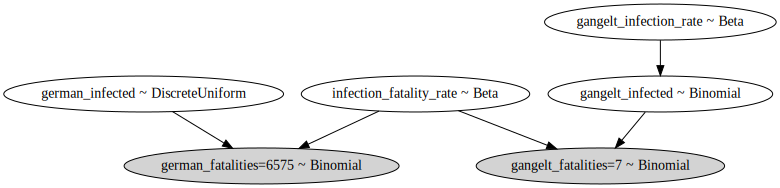

In [9]:
with pm.Model() as model:
    # the infection rate is given as 0.1553 [0.1231, 0.1896].
    gangelt_infection_rate = pm.Beta(**beta_params(mean=0.1553, var=((0.1896-0.1231)/4)**2), name='gangelt_infection_rate')
    
    total_population = 12597
    gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')
    
    infection_fatality_rate = pm.Beta(**beta_params(mean=0.1, var=0.1**2), name='infection_fatality_rate')
    gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities=7', observed=7)
    
    german_infected = pm.DiscreteUniform(lower=150000, upper=10000000, name='german_infected')
    german_fatalities = pm.Binomial(n=german_infected, p=infection_fatality_rate, observed=6575, name='german_fatalities=6575')
    
    display(pm.model_graph.model_to_graphviz(model))

### Inspecting the priors

let's have a look into the priors to see whether they align with our intuitions and are not too narrow

In [10]:
with model:
    prior = pm.sample_prior_predictive(samples=50000)

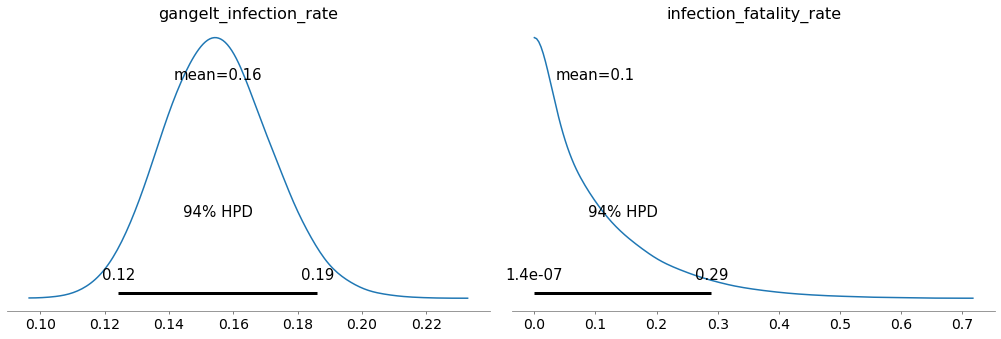

In [13]:
arviz.plot_posterior(prior, var_names=[
    'gangelt_infection_rate',
    'infection_fatality_rate',
]);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdfba1a0690>,
      dtype=object)

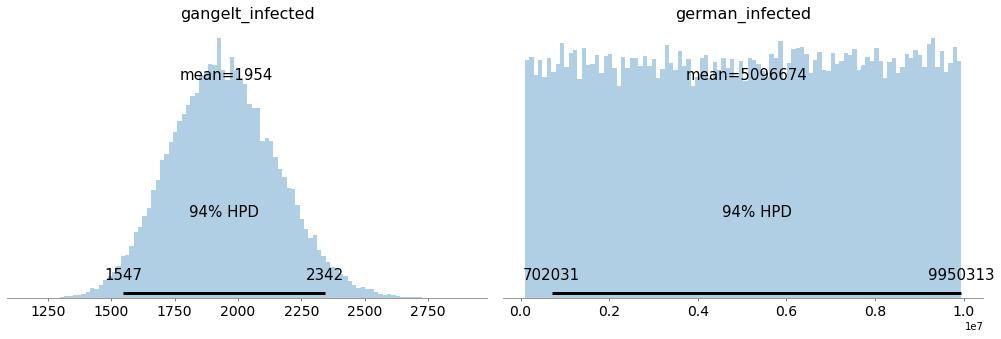

In [14]:
arviz.plot_posterior(prior, var_names=[
    'gangelt_infected',
    'german_infected'
], bins=100)

## Sampling the posterior

In [16]:
posterior = None

In [22]:
with model:
    posterior = pm.sample(draws=5000000, trace=posterior)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [infection_fatality_rate, gangelt_infection_rate]
>CompoundStep
>>Metropolis: [german_infected]
>>Metropolis: [gangelt_infected]
Sampling 4 chains, 0 divergences: 100%|██████████| 20002000/20002000 [2:29:08<00:00, 2235.23draws/s]  
The number of effective samples is smaller than 10% for some parameters.


In [18]:
pm.summary(posterior)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
gangelt_infected,1960.052,213.618,1554.000,2355.000,1.408,0.996,23016.0,23016.0,22984.0,90049.0,1.0
german_infected,2231392.209,1087302.986,771691.000,4067959.000,34478.886,28743.707,994.0,716.0,1578.0,1605.0,1.0
gangelt_infection_rate,0.156,0.017,0.125,0.187,0.000,0.000,23848.0,23848.0,23816.0,93729.0,1.0
infection_fatality_rate,0.004,0.001,0.001,0.006,0.000,0.000,1867.0,1867.0,1579.0,1604.0,1.0


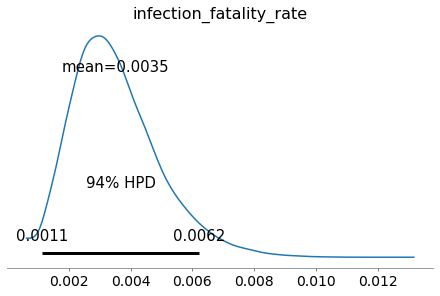

In [20]:
arviz.plot_posterior(posterior, var_names=[
    'infection_fatality_rate'
], bins=100);

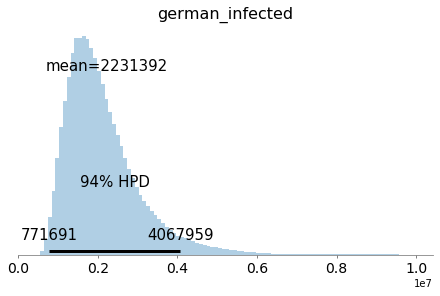

In [21]:
arviz.plot_posterior(posterior, var_names=[
    'german_infected'
], bins=100);